In [1]:
import numpy as np
import scipy as sp
import suite2p as s2p
import TwoPUtils as tpu
import InVivoDA_analyses as da
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from InVivoDA_analyses.path_dict_firebird import path_dictionary as path_dict
# options: path_dict_josquin, path_dict_msosamac, etc.
path_dict

{'preprocessed_root': '/data/2P',
 'sbx_root': '/mnt/oak/InVivoDA/2P_Data',
 'gdrive_root': '/mnt/gdrive/2P_Data',
 'VR_Data': '/data/2P/VR_Data',
 'git_repo_root': '/home/mari/local_repos/2p_repos',
 'TwoPUtils': '/home/mari/local_repos/2p_repos/TwoPUtils',
 'home': '/home/mari',
 'fig_dir': '/data/2P/fig_scratch'}

In [3]:
mouse = "SparseKO_03"
basedir = os.path.join(path_dict['preprocessed_root'],mouse) #"/mnt/BigDisk/2P_scratch/GRABDA15"
sbxdir = os.path.join(path_dict['sbx_root'],mouse) 

custom_nplanes = 1 # if needed to override empty optotune params

basedir, sbxdir

('/data/2P/SparseKO_03', '/mnt/oak/InVivoDA/2P_Data/SparseKO_03')

In [5]:

# file_list = stx3.ymaze_sess_deets.SparseKO_sessions[mouse]
file_list = [ {'date': '22_11_2024', 'scene': 'YMaze_LNovel_LongTimeout', 'session': 1, 'scan': 19, 'exp_day': 7} ]
file_list

[{'date': '22_11_2024',
  'scene': 'YMaze_LNovel_LongTimeout',
  'session': 1,
  'scan': 19,
  'exp_day': 7}]

In [7]:
for fn,f in enumerate(file_list):

    # Set data input and output paths
    fullpath = os.path.join(basedir,f['date'],f['scene'],"%s_%03d_%03d" % (f['scene'], f['session'], f['scan']))
    scanpath = os.path.join(sbxdir,f['date'],f['scene'],"%s_%03d_%03d" % (f['scene'], f['session'], f['scan']))
    h5path = os.path.join(basedir,f['date'],f['scene'],"%s_%03d_%03d.h5" % (f['scene'], f['session'], f['scan']))

    # load .mat header with metadata
    scanmat, sbxfile = scanpath+'.mat', scanpath+'.sbx'
    info = tpu.scanner_tools.sbx_utils.loadmat(scanmat, sbx_version=3)
    if len(info['etl_table'])>0:
        nplanes = info['etl_table'].shape[0]
    else:
        nplanes = custom_nplanes
        print('"etl_table" was empty; hardcoding %d planes' % nplanes)

    print('nplanes=',nplanes)

    # convert .sbx file to .h5
    h5name = tpu.scanner_tools.sbx_utils.sbx2h5(scanpath,output_name=h5path, sbx_version=3)
    
    # run suite2p to run motion registration AND extract ROIs on the first
    # functional channel (channel 1, green, PMT0)
    ops = tpu.s2p.set_ops(d={'data_path': [os.path.split(fullpath)[0]],
                           'save_path0': fullpath,
                           'fast_disk':[],
                           'move_bin':False,
                           'two_step_registration':True,
                           'maxregshiftNR':10,
                           'nchannels':2,
                           'tau': 0.7,
                           'functional_chan':1,
                           'nimg_init': 2000,
                           'fs':info['frame_rate'],
                           'roidetect':True,
                           'input_format':"h5",
                           'h5py_key':'data',
                           'sparse_mode':True,
                           'threshold_scaling':.6, #.6
                            'nplanes':nplanes})

    ops=s2p.run_s2p(ops=ops)

    # !rm {h5name} 

"etl_table" was empty; hardcoding 1 planes
nplanes= 1
{}
h5
** Found 1 h5 files - converting to binary **
NOTE: using a list of h5 files:
['/data/2P/SparseKO_03/22_11_2024/YMaze_LNovel_LongTimeout/YMaze_LNovel_LongTimeout_001_019.h5']
time 543.06 sec. Wrote 39964 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 39964 frames
Reference frame, 115.75 sec.
Registered 4000/39964 in 155.52s
Registered 6000/39964 in 230.14s
Registered 8000/39964 in 305.32s
Registered 10000/39964 in 378.90s
Registered 12000/39964 in 452.15s
Registered 14000/39964 in 523.88s
Registered 16000/39964 in 598.45s
Registered 18000/39964 in 669.39s
Registered 20000/39964 in 741.51s
Registered 22000/39964 in 812.81s
Registered 24000/39964 in 885.24s
Registered 26000/39964 in 956.44s
Registered 28000/39964 in 1029.04s
Registered 30000/39964

cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


>>>> CELLPOSE estimating masks in anatomical channel
>>>> 97 masks detected, median diameter = 8.21 
ERROR importing or running cellpose, continuing without anatomical estimates
----------- Total 159.73 sec.
----------- EXTRACTION
Masks created, 0.56 sec.


/home/mari/local_repos/2p_repos/suite2p/suite2p/extraction/extract.py:112: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  Fi[n] = np.dot(data[:, cell_ipix[n]], cell_lam[n])


Extracted fluorescence from 320 ROIs in 39964 frames, 39.28 sec.
Extracted fluorescence from 320 ROIs in 39964 frames, 61.02 sec.
----------- Total 101.22 sec.
----------- CLASSIFICATION
['skew', 'npix_norm', 'compact']
----------- Total 0.02 sec.
----------- SPIKE DECONVOLUTION
----------- Total 0.54 sec.
Plane 0 processed in 2137.25 sec (can open in GUI).
total = 2680.59 sec.
TOTAL RUNTIME 2680.59 sec


## Copy the original ops!

In [8]:
ops_orig = ops.copy()

## Option to copy binary files so you don't have to re-register

In [15]:
## Use the existing motion-registered binary and
# extract ROIs for functional channel 2 (red, PMT1)

ops = ops_orig.copy()
save_path_orig = ops_orig['save_path0']

# Make new save path, destination for new ops, stat, and copied binaries
ops['save_path'] = os.path.join(ops['save_path0'], 'chan2','suite2p', 'plane0')
os.makedirs(ops['save_path'], exist_ok=True)


In [51]:
import shutil

ops['fast_disk'] = [] # remove this so there's no confusion with save_path

orig_reg_file_1 = os.path.join(save_path_orig,'suite2p','plane0','data.bin') # the original data.nbin
orig_reg_file_2 = os.path.join(save_path_orig,'suite2p','plane0','data_chan2.bin') # the original data_chan2.nbin

# switch meanImg <-> meanImg_chan2
mimg = np.copy(ops_orig['meanImg'])
ops['meanImg'] = np.copy(ops_orig['meanImg_chan2'])
ops['meanImg_chan2'] = mimg

# copy chan2 reg file (original data_chan2.bin) to new location as "data.bin"
ops['reg_file'] = os.path.join(ops['save_path'], 'data.bin') # create a path for the new reg_file
shutil.copyfile(orig_reg_file_2, ops['reg_file'])
print('red reg_file_chan2 copied to %s'%(ops['reg_file']))

# now copy original chan1 reg file to new "data_chan2.bin"
ops['reg_file_chan2'] = os.path.join(ops['save_path'], 'data_chan2.bin') # create a path for the new chan2 reg_file
shutil.copyfile(orig_reg_file_1, ops['reg_file_chan2'])
print('green reg_file copied to %s'%(ops['reg_file_chan2']))


red reg_file_chan2 copied to /data/2P/SparseKO_03/22_11_2024/YMaze_LNovel_LongTimeout/YMaze_LNovel_LongTimeout_001_019/chan2/suite2p/plane0/data.bin
green reg_file copied to /data/2P/SparseKO_03/22_11_2024/YMaze_LNovel_LongTimeout/YMaze_LNovel_LongTimeout_001_019/chan2/suite2p/plane0/data_chan2.bin


In [53]:
# save new ops file with paths
ops['ops_path'] = os.path.join(ops['save_path'],'ops.npy')
ops['save_path0'] = os.path.join(ops['save_path0'], 'chan2') # need it to look here + suite2p/plane0/ for binaries that we copied

np.save(ops['ops_path'], ops)

In [61]:
## Optional: update ROI threshold for the second channel
ops['threshold_scaling'] = .85

In [23]:
import matplotlib.pyplot as plt

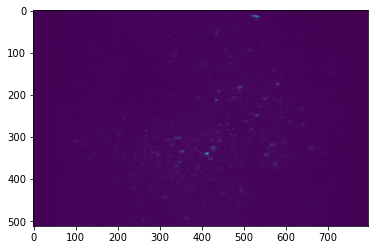

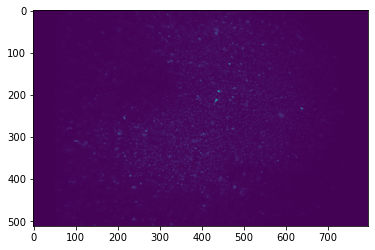

In [55]:
plt.figure()
plt.imshow(ops['meanImg_chan2'])

plt.figure()
plt.imshow(ops['meanImg'])

In [62]:
## Run the ROI extraction for the second channel
opsEnd=s2p.run_s2p(ops=ops)

{}
FOUND BINARIES AND OPS IN ['/data/2P/SparseKO_03/22_11_2024/YMaze_LNovel_LongTimeout/YMaze_LNovel_LongTimeout_001_019/chan2/suite2p/plane0/ops.npy']
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: /data/2P/SparseKO_03/22_11_2024/YMaze_LNovel_LongTimeout/YMaze_LNovel_LongTimeout_001_019/chan2/suite2p/plane0/data.bin
NOTE: applying default /home/mari/.suite2p/classifiers/classifier_user.npy
----------- ROI DETECTION
Binning movie in chunks of length 11
Binned movie [3516,416,694] in 76.91 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 2.93, threshold 12.45 
0 ROIs, score=218.56
1000 ROIs, score=15.89
Detected 1659 ROIs, 54.48 sec
After removing overlaps, 1473 ROIs remain


cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


>>>> CELLPOSE estimating masks in anatomical channel


/home/mari/anaconda3/envs/dope2p_rr/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mari/anaconda3/envs/dope2p_rr/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


>>>> 4 masks detected, median diameter = 5.52 
ERROR importing or running cellpose, continuing without anatomical estimates
----------- Total 146.86 sec.
----------- EXTRACTION
Masks created, 1.43 sec.
Extracted fluorescence from 1473 ROIs in 39964 frames, 53.58 sec.
Extracted fluorescence from 1473 ROIs in 39964 frames, 86.16 sec.
----------- Total 142.14 sec.
----------- CLASSIFICATION
['skew', 'npix_norm', 'compact']
----------- Total 0.03 sec.
----------- SPIKE DECONVOLUTION
----------- Total 2.43 sec.
moving binary files to save_path
Plane 0 processed in 291.56 sec (can open in GUI).
total = 291.92 sec.
TOTAL RUNTIME 291.92 sec


### You can now open both channels in suite2p

In [63]:
## OPTIONAL delete copied binaries from the chan2 path to save disk space
!rm {ops['reg_file']}
!rm {ops['reg_file_chan2']} 

In [ ]:
## Remove enormous h5 file
!rm {h5name} 